# Week 7 - Linear classification

Learning contents:
* Least squares for classification
* Perceptron
* Logistic regression
* Extra: multi-class logistic regression

In [588]:
# Dependencies
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # this import just makes the plots prettier
import numpy as np

# Support functions: 
def pseudoInvers(A):
    """
    A ∈ ℝ^BxC\n
    psedo(A) => Apseudo ∈ ℝ^CxB\n
    Why? \n
    (CxB @ BxC) => CxC -> CxC @ CxB => CxB\n
    """
    
    return np.linalg.inv(A.T @ A) @ (A.T)

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [589]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [590]:
# Handy plotting functions
x_min, x_max = -40, 40
y_min, y_max = -40, 40

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, n_class=2):
    plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.colorbar();
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_decision_boundary(data, weights):
    N, M = data.shape

    # yk = yj 
    # yk - yj = 0
    # w0kx0 + w1kx1 + w2kx2 - (w0jx0 + w1jx1 + w2jx2) = 0
    # When talking meshes. I only have weights for the linear regression between the clusters, meaning I have one array of weights. 
    
    # w0x0 + w1x1 + w2x2 = 0 
    # w0x0 is just the bias. 
    # w1x1 + w2x2 + b = 0 
    # w2x2 = -w1x1 - b
    # x2 = -(w1/w2)x1 - w0/w2 
    
    y = -
    x = data[:, 1] # Seems my plot is offcentered, it should rather start from mean of cluster 1 ≈ -5
    x += 25 # A small workaround. The better way had to start it from the multivariate mean of cluster 1. 
    plt.plot(x, y, 'g--', label='Decision Boundary')


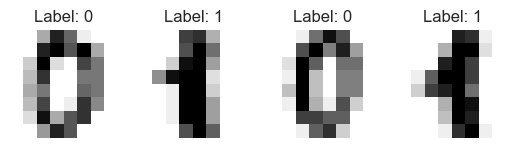

In [591]:
plot_examples()

In [592]:
# The dataset contains 2D data in the form of the `images` attribute, 
# as well as a 1D-version called `data`, where the images have been flattened. 
np.array_equal(digits.images[0].flatten(), digits.data[0])

True

In [593]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data)  # this is the representation, we'll be working with
X[:, 1] *=  -1 # The data of the 1st dimension is flipped. 

In [594]:
# Out targets are in the set {0,1}
t_01 = digits.target

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_22307/2802149535.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


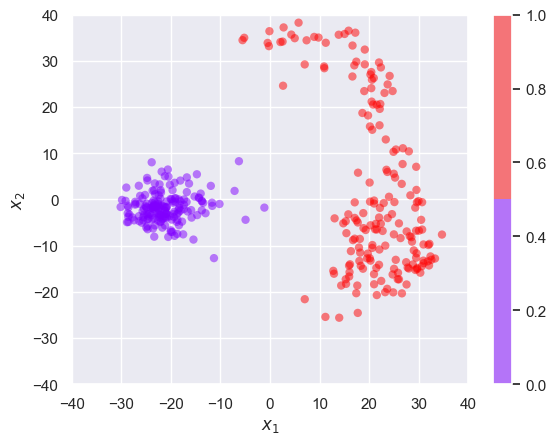

In [595]:
# Let's plot all the data in 2D
plot_scatter(X, t_01)

## 1) Least Squares

### 1.1) Find the weight vector using Least Squares for classification
Find the optimal weights **W** of size (M+1,1), where M is the size of each data point **X_n**={x_1n,...,x_Mn} , in this problem each **X_n** has size 2 because it has 2 coordinates. And where N is the number of data points.
<br>
To find the optimal weight calculation look at slides 13 and 15 of Lecture 13. Hint: Remember to augment the data with a column of 1's so that the initial weight, **w_0**, can  be multiplied by 1. 
<br>
This means: construct the matrix **X_least_squares** =[1,**x**], where **X** is the matrix of data points, in this case ***X** will have dimensions [N x M]* (N data points for every vector of M components, in this case with M=2 components/coordinates) and ***X_least_squares** will have dimensions [N x M+1]* (n datapoints with 2 coordinates and the extra row of 1's to multiply **w_0** by). Note that **X** ranges 1,...,N and each row in **X** ranges from 1 to M.


### 1.1) Goals rewritten
Find weights optimal - refer to slides 13 & 15 of lecture 13. <br>
**W** in **R^(M+1, 1)** <br>
**X** in **R^(NxM)** whilst **X_Least_Squares** in R^(NxM+1) to fit the size of the optimal weights.

In [596]:
def optimalWeights(X, T):
    N, M = X.shape
    Xtilde = np.zeros((N, M + 1))
    Xtilde[:, 0]= 1
    Xtilde[:, 1:3] = X
    
    # Pseudo(N, M+1) -> M+1xN @ NxM+1 => M+1xM+1 -> M+1xM+1 @ M+1xN => M+1xN
    # Ttilde in R^Nx1
    # M+1xN @ Nx1 => M+1x1
    Wtilde = pseudoInvers(Xtilde) @ T
    return (Xtilde, Wtilde)
Xtilde, Wtilde = optimalWeights(X, t_01)
print(Wtilde)

[0.50555556 0.02182423 0.00478603]


### 1.2) Create class predictions using the weight vector
Create a function called 'predict' that takes as arguments: the weights vector, **W**, found using the Least Squares method for classification in the previous step, the augmented data created by adding a row of 1's to the data, **X**, and a decision boundary, which will be scalar that will be used to determine the boundary of classification. The function should return the predictions for each data point, so it should return an array of [Nx1] values, based on the decision boundary value for classification. See slide 13, Lecture 13. Finally, check that the predictions are the same than the original target vector.

In [597]:
def predict(Wtilde, X): 
    N, M = X.shape
    Xtilde = np.zeros((N, M + 1))
    Xtilde[:, 0] = 1
    Xtilde[:, 1:3] = X
    # Decision boundary for Ck og Cj => yk = yj.
    # 1xM+1 @ NxM+1    
    
    # Xtilde ∈ ℝ^NxM+1 
    # xtilde ∈ ℝ^M+1x1 just a vector of the Xtilde matrix. It's dimension is of a vectors, down the rows. 
    
    # Is this possible with linear algebra? 
    
    # Wtilde.T @ Xtilde.T ? 
    # 
    #                   [     ,   ...   ,   N  ]                [w0*x00 + w1*x10 +..., w2*xM0]
    # [  , ... , M+1] @ [  ...,   ...   ,  ... ]            =   [...    +   ...  +  ...  ]
    #                   [M+1x1,  M+1x..., M+1xN]                [w0*x0N + w1*x1N +..., w2*xMN]
    # 
    
    # Should be right? 
    # For Wtilde.T @ xtilde you times the weights with the dimensions in the datapoint. You do the same here. 
    # Saying Wtilde.T @ Xtilde.T should just give me an array of Y, where each row represents yk = Wtilde.T @ xtildek
    y = Wtilde.T @ Xtilde.T
    
    # Now for the predictions. 
    # So the boundary is found where yk = yj = boundary holds. 
    # I should then be able to charecterize them by whose lower than the boundary, and who's higher than the boundary. 
    
    # For upper boundary I assign them 1. 
    boundary = Wtilde[0]
    predicts = np.array([1 if y[n] > boundary else 0 for n in range(N)])
    return predicts
    
predicts = predict(Wtilde, X) 
print(np.array_equal(predicts, t_01))
    

True


### 1.3) Plot the decision boundary 
You can do this either by plotting a line on the boundary or creating a mesh of all predictions. Substitute in the code below **W_least_squares** and **X_least_squares** by the names you have defined them in the previous steps, in order to show the plot.

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_22307/2802149535.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


NameError: name 'y' is not defined

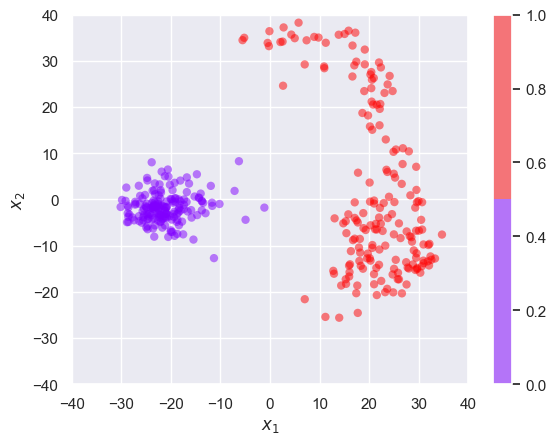

In [598]:
plot_scatter(X, t_01)
plot_decision_boundary(Xtilde, Wtilde)

## ----------------- Post plot comment ----------------- <br>
It seems as my slope of the decision boundary is fine, but it's somehow off-centered. <br>
I illustrated how it would have looked, if it were perfectly centered, by offsetting it such that it started from what I guessed to be a possible mean to the first cluster. 

## 2) Perceptron

Implement the perceptron algorithm for classification (see slide 20 of Lecture 13) for 1000 epochs. For this, consider PHI(X) as a polynomial basis of order D=1, this means PHI(X)_n = { 1, X }, so PHI(X) will have dimensions [Nx(MxD+1)]. In this case D=1 (polynomial of order 1), M=2 (each data point X_n has two coordinates) and N is 360 data points. Assume that the data is already suffled. To initialize the weight vector w_0, we set the random seed to 13 and make that the weight vector is in the range of {-1,1}. In addition, a learning_rate of 0.1 should do the job.
Hint: remember to change the target representation range so that each data point will have a class of -1 or 1.

## 2) Problem 
We want the perceptron algorithm to solve for classifications <br>
We want our nonlinear basis to be of size NxMxD+1, with **Phi(X)_n** = {1, **X**} <br>
**N** = 360, **M** = 2, **D** = 1 <br>
**w0** should be initialized to be in range {-1, 1} and it's random seed set to 13.
We set the learning rate to 0.1

In [585]:
np.random.seed(13)
w0 = np.random.uniform(-1, 1, 1)
print(w0)


[0.55540482]


### 2.2) Perform class-predictions
Again, you should be able to classify all correctly by checking that the predictions are the same as the provided target vector. Notice both predictions and target vector are an array of N components of 0's and 1's, so you have to make your predictions go back to 1's and 0's instead of -1's and 1's.

### 2.3) Plot the decision boundary
To plot the decision boundary, adapt the names from your weights and PHI matrix in the code below.

## 3) Logistic Regression
### 3.1) Find the weight vector using the Logistic Regression
To find the weight vector compute the gradient of error function with respect to **w** , Delta(E(**w**)) (see slide 20 of Lecture 14). **PHI(X)** has dimensions [Nx(M+1)], so it only has an added row of 1's, in this case it has dimension 360x3. And then, considering that **w_0** is provided by initializing it randomly, do, for 30 epochs a weight update: w (tau +1) = w (tau ) − (learning rate) * deltaE (w (tau ))

In [567]:
# initialise W_0 randomly
np.random.seed(42)
W_0 = 2 * np.random.random((1, 3)) -1 # random values in the range [-1,1]

# Our target vectors should be {0, 1}
t_01 = digits.target

### 3.2) Perform class-predictions

### 3.3) Plot the decision boundary
Replace W_logistic and X_logistic with the name of your data.

## 4) Multi-class logistic regression
Repeat 3) but now for multiple classes, i.e. compute the weight matrix, perform predictions (you shold be able to get about 93% accuracy) and plot decision boundaries.

Hint: You will need to use a one-hot encoding of the targets

In [568]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=2)
X_mult = pca.fit_transform(digits.data)

learning_rate = 0.1

# We need to do a one_hot encoding of our data:
# I.e. 0 -> [1,0,0], 1 -> [0,1,0], 2 -> [0,0,1]
def one_hot(targets, n_class=n_class):
    res = np.eye(n_class)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[n_class])

t_oh = one_hot(digits.target, n_class)

/var/folders/s1/8pjch1gd44lcppl6nnk77kdh0000gn/T/ipykernel_22307/141546007.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', n_class))


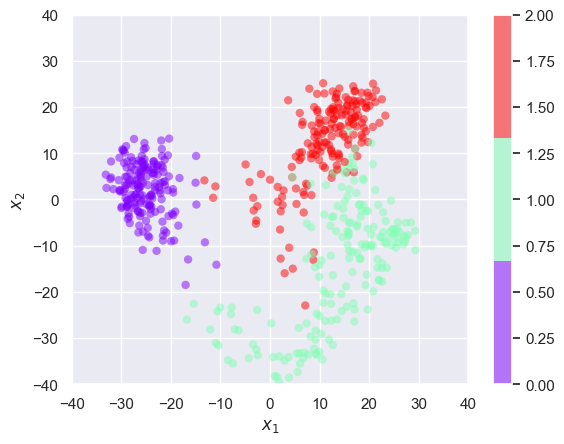

In [569]:
plot_scatter(X_mult, digits.target, n_class=n_class)

## 5) (Optional) Multi-class logistic regression on original data representation
Repeat exercise 4), but use the original data representation instead.
You can omit the plots.

Hint: To get 100% accuracy, you can try to:
- Rescale your data to the range [0,1]
- Run 1000 epochs with learning_rate = 0.1